# 손실함수 (Loss Function)

In [20]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [21]:
y_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = np.array([1.2, 1.8, 3.1, 3.9, 4.8])

# y_true = np.append(y_true, [50.0, 60.0])  # 이상치를 넣어줬을때 mse, mae의 변화를 보기 위함 
# y_pred = np.append(y_pred, [10.0, 5.0])


mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)


print("MSE", mse)
print("MAE", mae)

MSE 0.028000000000000014
MAE 0.16000000000000006


In [22]:
# Huber Loss
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error **2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss(y_true, y_pred)  # 이상치가 들어가도 안정적으로 손실값을 계산해줌 

np.float64(0.014000000000000007)

### 신경망 모델에서 손실 함수 활용

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
# 데이터 생성
X, y = make_classification(
    n_samples=1000,     
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

# 전처리
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train, 2)
y_test_oh = one_hot(y_test, 2)

In [25]:
# 모델 파라미터 초기화
np.random.seed(42)

input_dim = X_train.shape[1]    # X_train.shape = (전체 샘플 수, 특성 수) -> X_train.shape[1] : 특성의 수
hidden_dim = 32                 
output_dim = 2                  # n_classes 

W1 = np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))

In [ ]:
# 활성화 함수, 손실 함수 정의
def relu(z):
    return np.maximum(0, z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(probs, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(probs + 1e-8) * labels     # 1e-8 = 1*10^(-8) -> 로그 값이 0이 되는 문제 방지 
    loss = np.sum(log_likelihood) / m
    return loss

In [29]:
# 학습
learning_rate = 0.01    # 학습률
epochs = 500             # 반복 횟수 50번
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Forward
    Z1 = np.dot(X_train, W1) + b1               # 입력층에서 은닉층으로    / 선형변환
    R1 = relu(Z1)   # (hidden_dim, output_dim)  # 은닉층에서의 output R1  / 은닉층 활성화함수 ReLU
    Z2 = np.dot(R1, W2) + b2                    # 은닉층에서 출력층으로    / 선형변환
    probs = softmax(Z2)                         # 출력층 활성화 함수 softmax
    loss = cross_entropy_loss(probs, y_train_oh)    # 손실 계산 

    # Backporpagation
    m = X_train.shape[0]    # 데이터 개수 (N)
    dZ2 = (probs - y_train_oh) / m  #(N, output_dim)        (잔차의 평균)   N : 데이터 샘플의 수  / 출력층에서의 오차, 출력층 그래디언트 
    dW2 = np.dot(R1.T, dZ2)                     # 손실을 기준으로 가중치와 편향의 기울기 구하기    / 은닉층 -> 출력층 가중치 기울기 
    db2 = np.sum(dZ2, axis=0, keepdims=True)        # 출력층 편향 기울기 

    dR1 = np.dot(dZ2, W2.T)                     # 출력층 오차를 은닉층으로 전파
    dZ1 = dR1 * (Z1 > 0)                        # ReLU에서 Z1이 0보다 크면 기울기1, Z1이 0보다 작으면 기울기 0 -> Z1이 0보다 큰 경우에만 dR1을 전달, 0이하면 0
    dW1 = np.dot(X_train.T, dZ1)                # 입력층 -> 은닉층 가중치 기울기
    db1 = np.sum(dZ1, axis=0, keepdims=True)    # 은닉층 편향 기울기 
    
    # 파라미터 업데이터
    W1 -= learning_rate * dW1       # 경사하강법
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2       # epoch 1회 끝 
    
    train_losses.append(loss)
    
    # 테스트 데이터로 손실 확인
    Z1_test = np.dot(X_test, W1) + b1
    R1_test = relu(Z1_test)   # (hidden_dim, output_dim)
    Z2_test = np.dot(R1_test, W2) + b2
    probs_test = softmax(Z2_test)
    loss_test = cross_entropy_loss(probs_test, y_test_oh)   # 테스트 데이터에 대해 순전파 수행 후 손실계산 

    test_losses.append(loss_test)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1} | 학습손실: {loss:.4f}, 테스트 손실: {loss_test:.4f}')  # 10에포크마다 손실 출력

    

Epoch 10 | 학습손실: 2.9433, 테스트 손실: 3.0472
Epoch 20 | 학습손실: 2.7649, 테스트 손실: 2.8778
Epoch 30 | 학습손실: 2.6023, 테스트 손실: 2.7088
Epoch 40 | 학습손실: 2.4508, 테스트 손실: 2.5528
Epoch 50 | 학습손실: 2.3104, 테스트 손실: 2.4099
Epoch 60 | 학습손실: 2.1785, 테스트 손실: 2.2771
Epoch 70 | 학습손실: 2.0530, 테스트 손실: 2.1531
Epoch 80 | 학습손실: 1.9347, 테스트 손실: 2.0429
Epoch 90 | 학습손실: 1.8250, 테스트 손실: 1.9495
Epoch 100 | 학습손실: 1.7245, 테스트 손실: 1.8698
Epoch 110 | 학습손실: 1.6315, 테스트 손실: 1.7998
Epoch 120 | 학습손실: 1.5465, 테스트 손실: 1.7382
Epoch 130 | 학습손실: 1.4692, 테스트 손실: 1.6818
Epoch 140 | 학습손실: 1.3987, 테스트 손실: 1.6290
Epoch 150 | 학습손실: 1.3340, 테스트 손실: 1.5781
Epoch 160 | 학습손실: 1.2752, 테스트 손실: 1.5282
Epoch 170 | 학습손실: 1.2208, 테스트 손실: 1.4785
Epoch 180 | 학습손실: 1.1708, 테스트 손실: 1.4291
Epoch 190 | 학습손실: 1.1250, 테스트 손실: 1.3807
Epoch 200 | 학습손실: 1.0832, 테스트 손실: 1.3342
Epoch 210 | 학습손실: 1.0449, 테스트 손실: 1.2897
Epoch 220 | 학습손실: 1.0096, 테스트 손실: 1.2471
Epoch 230 | 학습손실: 0.9771, 테스트 손실: 1.2064
Epoch 240 | 학습손실: 0.9473, 테스트 손실: 1.1679
Epoch 250 | 학습손실: 0.9196,

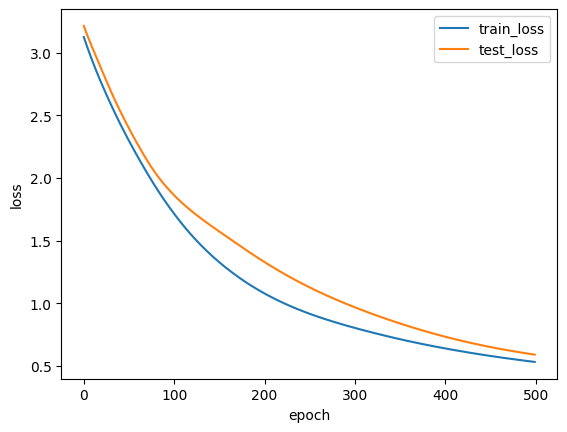

In [30]:
# 시각화
plt.plot(range(epochs), train_losses, label='train_loss')
plt.plot(range(epochs), test_losses, label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 기본 손실 함수 vs 커스텀 손실 함수

In [32]:
from sklearn.datasets import make_regression

# 데이터 생성
X, y = make_regression(
    n_samples=1000,
    n_features=10,
    noise=50,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# 예측 함수
def predict(X, w, b):
    return np.dot(X, w) + b

In [35]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

def my_loss(y_pred, y_true, w, lambda_reg=1.0):
    mse = mse_loss(y_pred, y_true)
    l2_reg = np.sum(w ** 2)
    return mse + (lambda_reg * l2_reg)  # 괄호 안은 규제정도를 곱해주는 부분

In [40]:
def train_model(X_train, y_train, X_test, y_test, 
                loss_fn, 
                epochs=50, 
                learning_rate=0.1, 
                use_custom=False):
    np.random.seed(42)
    n_features = X_train.shape[1]
    W = np.random.randn(n_features)
    b = 0.0

    for epoch in range(epochs):
        y_pred_train = predict(X_train, W, b)
        y_pred_test = predict(X_test, W, b)

        train_loss = loss_fn(y_pred_train, y_train, W) if use_custom else loss_fn(y_pred_train, y_train)
        test_loss = loss_fn(y_pred_test, y_test, W) if use_custom else loss_fn(y_pred_test, y_test)

        d_loss = 2 * (y_pred_train - y_train) / X_train.shape[0]
        grad_w = np.dot(X_train.T, d_loss)
        grad_b = np.sum(d_loss)

        if use_custom:
            grad_w += 2 * 1.0 * W

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if(epoch +1) % 10 == 0:
            print(f'Epoch {epoch + 1} | 학습 손실: {train_loss:.4f}, 테스트 손실: {test_loss:.4f}')


In [41]:
train_model(X_train, y_train, X_test, y_test, mse_loss)

Epoch 10 | 학습 손실: 0.1782, 테스트 손실: 0.1833
Epoch 20 | 학습 손실: 0.1216, 테스트 손실: 0.1255
Epoch 30 | 학습 손실: 0.1209, 테스트 손실: 0.1242
Epoch 40 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 50 | 학습 손실: 0.1209, 테스트 손실: 0.1241


In [43]:
train_model(X_train, y_train, X_test, y_test, my_loss, use_custom=True)     # 규제를 적용했을 때 과대적합이 방지, 규제 없을 경우보다 학습 데이터 대비 테스트 데이터에 대한 손실이 줄어든 것을 확인할 수 있다 

Epoch 10 | 학습 손실: 0.5709, 테스트 손실: 0.5544
Epoch 20 | 학습 손실: 0.5698, 테스트 손실: 0.5548
Epoch 30 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 40 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 50 | 학습 손실: 0.5698, 테스트 손실: 0.5550


### 손실 함수 선택이 모델 성능에 미치는 영향

In [44]:
X, y = make_regression(
    n_samples=1000,
    n_features=5,
    noise=30,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
# 선형 회귀 모델 예측 함수
def predict(X, W, b):
    return np.dot(X, W) + b

In [47]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)


def mae_loss(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true))


def huber_loss(y_pred, y_true, delta=1.0):
    error = y_pred - y_true
    is_small_error = np.abs(error) <= delta
    squared_error = 0.5 * error**2
    linear_error = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_error, linear_error))

In [50]:
def train_regression(X, y, loss_fn, epochs=100, learning_rate=0.01):
    n_features = X.shape[1]
    W = np.random.randn(n_features)
    b = 0.0
    m = X.shape[0]  # X데이터의 샘플 개수 
    epsilon = 1e-5
    losses = []

    for epoch in range(epochs):
        y_pred = predict(X, W, b)
        loss = loss_fn(y_pred, y)
        losses.append(loss)

        grad_w = np.zeros_like(W)
        for i in range(len(W)):
            W_eps = np.copy(W)
            W_eps[i] += epsilon
            loss_eps = loss_fn(predict(X, W_eps, b), y)
            grad_w[i] = (loss_eps - loss) / epsilon

        b_eps = b + epsilon
        loss_eps_b = loss_fn(predict(X, W, b_eps), y)
        grad_b = (loss_eps_b - loss) / epsilon

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b 

    return W, b, losses

In [70]:
results = {}

for name, loss_fn in zip(["MSE", "MAE", "Huber"], [mse_loss, mae_loss, huber_loss]):
    W, b, losses = train_regression(X_train, y_train, loss_fn)
    results[name] = {"losses": losses}
    
    pred_test = predict(X_test, W, b)
    test_loss = mse_loss(pred_test, y_test)
    print(f'{name} Loss: {test_loss:.4f}')

MSE Loss: 0.3705
MAE Loss: 3.8244
Huber Loss: 1.0369


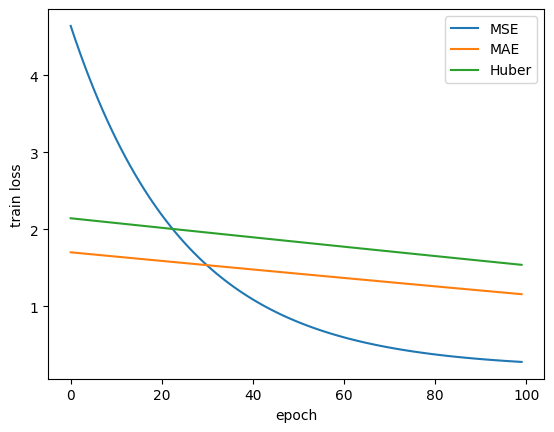

In [53]:
# print(results.items())
# 시각화

for name, value in results.items():
    plt.plot(value["losses"], label=name)

plt.xlabel('epoch')
plt.ylabel('train loss')
plt.legend()
plt.show()